<a href="https://colab.research.google.com/github/rero265/TumorDetectionHackathon/blob/main/50ep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

# 🖼️ Computer Vision
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms.functional import to_pil_image

# 📊 Utilities
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import os

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import os
import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import ResNet18_Weights

# -----------------------------
# 1. Download the dataset
# -----------------------------
dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Dataset downloaded at:", dataset_path)

# If it's a zip file, extract it
import zipfile
extract_dir = "brain_tumor_dataset"
if dataset_path.endswith(".zip"):
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
else:
    extract_dir = dataset_path  # already extracted folder

# -----------------------------
# 2. Set up directories
# -----------------------------
train_dir = os.path.join(extract_dir, "Training")
test_dir  = os.path.join(extract_dir, "Testing")

# -----------------------------
# 3. Set up transforms and dataset
# -----------------------------
weights = ResNet18_Weights.DEFAULT

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    weights.transforms()  # ImageNet normalization
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data  = datasets.ImageFolder(test_dir, transform=transform)

# -----------------------------
# 4. Split train into train/validation
# -----------------------------
train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size
train_ds, val_ds = random_split(train_data, [train_size, val_size])

# -----------------------------
# 5. Create DataLoaders
# -----------------------------
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)

class_names = train_data.classes
print("Classes:", class_names)


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Dataset downloaded at: /kaggle/input/brain-tumor-mri-dataset
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [7]:
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [8]:
model = BrainTumorCNN().to(device)

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Freeze base layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 classes

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

def train_model(model, train_loader, val_loader, epochs=20):
    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()

        train_acc = correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                val_correct += (out.argmax(1) == y).sum().item()
        val_acc = val_correct / len(val_loader.dataset)

        print(f" Epoch {epoch+1:02d}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

In [10]:
train_model(model, train_loader, val_loader, epochs=50)


 Epoch 01: Train Acc = 0.7599, Val Acc = 0.8741
 Epoch 02: Train Acc = 0.8523, Val Acc = 0.8864
 Epoch 03: Train Acc = 0.8693, Val Acc = 0.9161
 Epoch 04: Train Acc = 0.8751, Val Acc = 0.9231
 Epoch 05: Train Acc = 0.8881, Val Acc = 0.9336
 Epoch 06: Train Acc = 0.8872, Val Acc = 0.9283
 Epoch 07: Train Acc = 0.8961, Val Acc = 0.9301
 Epoch 08: Train Acc = 0.9010, Val Acc = 0.9371
 Epoch 09: Train Acc = 0.9010, Val Acc = 0.9318
 Epoch 10: Train Acc = 0.8984, Val Acc = 0.9441
 Epoch 11: Train Acc = 0.9019, Val Acc = 0.9371
 Epoch 12: Train Acc = 0.9082, Val Acc = 0.9493
 Epoch 13: Train Acc = 0.9086, Val Acc = 0.9476
 Epoch 14: Train Acc = 0.9091, Val Acc = 0.9406
 Epoch 15: Train Acc = 0.9080, Val Acc = 0.9458
 Epoch 16: Train Acc = 0.9101, Val Acc = 0.9493
 Epoch 17: Train Acc = 0.9158, Val Acc = 0.9493
 Epoch 18: Train Acc = 0.9187, Val Acc = 0.9563
 Epoch 19: Train Acc = 0.9181, Val Acc = 0.9476
 Epoch 20: Train Acc = 0.9163, Val Acc = 0.9510
 Epoch 21: Train Acc = 0.9200, Val Acc =

In [11]:
# Save model
torch.save(model.state_dict(), "resnet18_brain_tumor.pth")

print("Model saved.")

# Load model later
# model.load_state_dict(torch.load("/kaggle/working/brain_resnet18.pth"))
# model.eval()


Model saved.


In [13]:
model.eval()
correct = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        correct += (out.argmax(1) == y).sum().item()

test_acc = correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9001


In [14]:
def grad_cam(model, input_tensor, target_class):
    model.eval()

    # Store gradients and activations
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks on layer4
    hook_f = model.layer4.register_forward_hook(forward_hook)
    hook_b = model.layer4.register_backward_hook(backward_hook)

    # Forward pass
    output = model(input_tensor.unsqueeze(0))
    model.zero_grad()

    class_score = output[0, target_class]
    class_score.backward()

    # Detach hooks
    hook_f.remove()
    hook_b.remove()

    # Get saved tensors
    grads = gradients[0].squeeze()
    acts = activations[0].squeeze()

    # Weighted average
    weights = grads.mean(dim=[1, 2])
    cam = torch.zeros(acts.shape[1:], dtype=torch.float32).to(device)

    for i, w in enumerate(weights):
        cam += w * acts[i]

    # Normalize heatmap
    cam = cam.cpu().detach().numpy()
    cam = np.maximum(cam, 0)
    cam = cam / cam.max() if cam.max() != 0 else cam

    return cam

In [15]:
def grad_cam(model, input_tensor, target_class):
    model.eval()

    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Register hooks on the LAST CONV block (ResNet18: layer4)
    hook_f = model.layer4.register_forward_hook(forward_hook)
    hook_b = model.layer4.register_full_backward_hook(backward_hook)

    # Forward pass
    output = model(input_tensor.unsqueeze(0))
    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward()

    # Clean up hooks
    hook_f.remove()
    hook_b.remove()

    # Sanity check
    if not gradients or not activations:
        raise RuntimeError("Gradients or activations were not captured. Check.")

    # Convert to CAM
    grads = gradients[0].squeeze(0)        # shape: (C, H, W)
    acts = activations[0].squeeze(0)       # shape: (C, H, W)
    weights = grads.mean(dim=[1, 2])       # shape: (C,)

    cam = torch.zeros(acts.shape[1:], dtype=torch.float32).to(device)
    for i, w in enumerate(weights):
        cam += w * acts[i]

    cam = cam.cpu().detach().numpy()
    cam = np.maximum(cam, 0)
    cam = cam / cam.max() if cam.max() != 0 else cam

    return cam


In [16]:
model.eval()
correct = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        correct += (preds.argmax(1) == y).sum().item()

test_acc = correct / len(test_loader.dataset)
print(f" Test Accuracy: {test_acc:.4f}")

 Test Accuracy: 0.9001


FileUpload(value={}, accept='.jpg,.jpeg,.png', description='Upload')

 Uploaded: Tr-me_0016.jpg


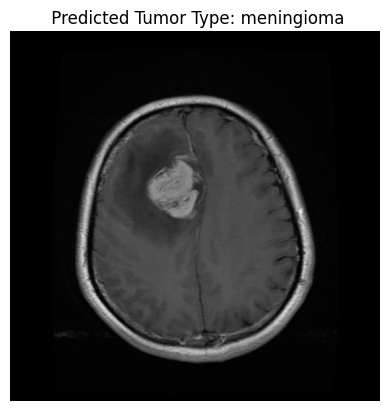

 Uploaded: Tr-pi_0036.jpg


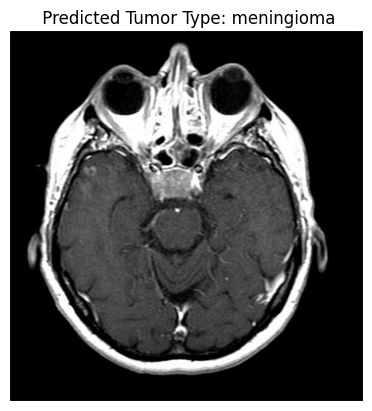

In [20]:
import io
from PIL import Image
import ipywidgets as widgets
from IPython.display import display

# Reuse the transform
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    weights.transforms()  # normalization (ImageNet mean/std)
])

# Label mapping
idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}

# Prediction function
def predict_uploaded_image(uploaded_file, model, device=device):
    model.eval()
    img = Image.open(io.BytesIO(uploaded_file)).convert("RGB")
    img_t = inference_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        _, pred = torch.max(outputs, 1)

    class_name = idx_to_class[pred.item()]

    # Show image + prediction
    plt.imshow(img)
    plt.title(f" Predicted Tumor Type: {class_name}")
    plt.axis("off")
    plt.show()

# FileUpload widget
uploader = widgets.FileUpload(accept='.jpg,.jpeg,.png', multiple=False)

def on_upload_change(change):
    for filename, fileinfo in uploader.value.items():
        print(f" Uploaded: {filename}")
        predict_uploaded_image(fileinfo['content'], model)

uploader.observe(on_upload_change, names='value')
display(uploader)


In [31]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.8 MB/s eta 0:00:00


In [42]:
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch
from reportlab.platypus import Image as RLImage
import datetime
import os

def generate_doctor_report(
    patient_id,
    patient_name,
    age,
    gender,
    image_path,
    heatmap_path,
    prediction,
    confidence,
    save_path="patient_report.pdf"
):
    c = canvas.Canvas(save_path, pagesize=A4)
    width, height = A4

    # -------------------------
    # Header (Hospital info)
    # -------------------------
    c.setFont("Helvetica-Bold", 18)
    c.drawString(180, height - 50, "AI Radiology Report")
    c.setFont("Helvetica", 12)
    c.drawString(200, height - 70, "Brain MRI Tumor Detection System")

    # -------------------------
    # Patient Information
    # -------------------------
    c.setFont("Helvetica-Bold", 14)
    c.drawString(50, height - 110, "Patient Information")
    c.setFont("Helvetica", 12)
    c.drawString(50, height - 130, f"Patient ID   : {patient_id}")
    c.drawString(50, height - 150, f"Name         : {patient_name}")
    c.drawString(50, height - 170, f"Age/Gender   : {age} / {gender}")
    c.drawString(50, height - 190, f"Report Date  : {datetime.date.today()}")

    # -------------------------
    # Diagnosis Result
    # -------------------------
    c.setFont("Helvetica-Bold", 14)
    c.drawString(50, height - 230, "AI Diagnosis Result")
    c.setFont("Helvetica", 12)
    c.drawString(50, height - 250, f"Predicted Tumor Type : {prediction}")
    c.drawString(50, height - 270, f"Confidence           : {confidence:.2f}%")

    # -------------------------
    # MRI + Heatmap
    # -------------------------
    c.setFont("Helvetica-Bold", 14)
    c.drawString(50, height - 310, "MRI Scan & Model Explanation")

    if os.path.exists(image_path):
        c.drawImage(image_path, 50, height - 550, width=200, height=200)

    if os.path.exists(heatmap_path):
        c.drawImage(heatmap_path, 300, height - 550, width=200, height=200)

    # -------------------------
    # Remarks / Disclaimer
    # -------------------------
    c.setFont("Helvetica-Bold", 14)
    c.drawString(50, 120, "Remarks")
    c.setFont("Helvetica", 11)
    text = (
        "This AI-assisted analysis suggests the presence of a brain tumor. "
        "The highlighted regions in the MRI indicate areas of potential abnormality. "
        "This report is intended to assist radiologists and should not be considered "
        "a final medical diagnosis. Please consult a certified medical professional."
    )
    c.drawString(50, 100, text[:95])
    c.drawString(50, 85, text[95:190])
    c.drawString(50, 70, text[190:])

    # -------------------------
    # Signature
    # -------------------------
    c.setFont("Helvetica-Oblique", 12)
    c.drawString(400, 50, "Doctor/AI Specialist")
    c.line(400, 45, 550, 45)  # signature line

    # Save PDF
    c.save()
    print(f" Report saved at {save_path}")


In [43]:
generate_doctor_report(
    patient_id="P123",
    patient_name="John Doe",
    age=45,
    gender="Male",
    image_path="example_mri.png",       # original MRI
    heatmap_path="example_heatmap.png", # Grad-CAM image
    prediction="Glioma Tumor",
    confidence=87.5,
    save_path="JohnDoe_Report.pdf"
)


 Report saved at JohnDoe_Report.pdf
